In [97]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import xgboost as xgb

from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

from tabulate import tabulate

# **Wind Farm #3**

In [98]:
DATA_PATH = 'Datasets'

df_wf1 = pd.read_excel(
    os.path.join(DATA_PATH,'Wind farm site 3 (Nominal capacity-99MW).xlsx'), 
)

pd.set_option('display.max_columns', None)
df_wf1

,Time(year-month-day h:m:s),Wind speed at height of 10 meters (m/s),Wind direction at height of 10 meters (˚),Wind speed at height of 30 meters (m/s),Wind direction at height of 30 meters (˚),Wind speed at height of 50 meters (m/s),Wind direction at height of 50 meters (˚),Wind speed - at the height of wheel hub (m/s),Wind speed - at the height of wheel hub (˚),Air temperature (°C),Atmosphere (hpa),Relative humidity (%),Power (MW)
0,2019-01-01 00:00:00,2.32218,317.431,2.59042,312.468,1.62735,351.117,2.34887,313.33,26.460,984.370,31.7949,-0.365790
1,2019-01-01 00:15:00,2.32218,317.431,2.59042,312.468,1.62735,351.117,2.34887,313.33,26.460,984.370,31.7949,-0.376874
2,2019-01-01 00:30:00,2.32218,317.431,2.59042,312.468,1.62735,351.117,2.34887,313.33,26.460,984.370,31.7949,-0.387959
3,2019-01-01 00:45:00,2.32218,317.431,2.59042,312.468,1.62735,351.117,2.34887,313.33,26.460,984.370,31.7949,-0.395348
4,2019-01-01 01:00:00,2.32218,317.431,2.59042,312.468,1.62735,351.117,2.34887,313.33,26.460,984.370,31.7949,-0.384264
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70171,2020-12-31 22:45:00,8.62000,159.000,9.04000,172.400,9.67280,162.401,9.61000,167.30,-5.476,977.088,42.4833,57.983200
70172,2020-12-31 23:00:00,8.88000,163.900,8.99000,180.200,9.61930,169.748,8.93000,171.20,-5.197,976.939,42.6886,58.700000
70173,2020-12-31 23:15:00,9.77000,160.600,9.78000,173.600,10.46460,163.531,9.69000,168.20,-5.084,976.790,43.5779,63.178200
70174,2020-12-31 23:30:00,8.93000,162.100,8.92000,173.800,9.54440,163.720,9.22000,169.50,-5.184,976.641,44.0568,59.039900


In [99]:
df_wf1.columns=['time','WS_10','WD_10','WS_30','WD_30','WS_50','WD_50','WS_cen','WD_cen','Air_T','Air_P','Air_H','Power(MW)']

In [100]:
df_wf1.columns = [col.strip() for col in df_wf1.columns]

In [101]:
df_wf1.describe()

,time,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
count,70176,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000
mean,2020-01-01 11:52:30,3.589179,148.329229,5.381621,145.127802,4.932602,143.019034,4.038722,179.948513,17.511213,971.787024,58.809449,18.167233
min,2019-01-01 00:00:00,0.000000,0.000000,0.000000,0.002874,0.000000,0.000000,0.000000,0.000000,-14.270000,950.958000,3.436560,-0.668767
25%,2019-07-02 17:56:15,0.000000,82.300000,3.180000,59.526000,2.661000,56.995150,1.127000,119.000000,10.470000,966.243000,39.736650,0.642903
50%,2020-01-01 11:52:30,3.158670,148.338000,4.957000,162.332000,4.573000,149.560500,3.855000,165.647000,20.500000,971.877000,57.142850,8.394690
75%,2020-07-02 05:48:45,5.712000,182.700000,7.102500,198.838750,6.915000,180.958000,5.984670,290.410500,26.460000,976.935000,77.371400,27.951500
max,2020-12-31 23:45:00,27.926000,360.000000,22.091700,360.000000,21.836000,360.000000,36.920300,360.000000,36.320000,990.731000,100.000000,94.266600
std,NaN,3.342172,97.895041,2.956940,88.322158,3.240955,93.320926,3.299241,110.122651,9.838062,6.853991,23.501034,22.632437


In [102]:
df_wf1[df_wf1['Power(MW)'] == 0.0]

,time,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
18183,2019-07-09 09:45:00,0.000,291.1680,2.66100,19.0263,2.661,281.6740,0.000,105.844,21.71,965.501,90.7922,0.0
18184,2019-07-09 10:00:00,0.000,291.1680,2.66100,19.0263,2.661,281.6740,0.000,105.844,21.71,965.501,90.7922,0.0
18185,2019-07-09 10:15:00,0.000,291.1680,2.66100,19.0263,2.661,281.6740,0.000,105.844,21.71,965.501,90.7922,0.0
18186,2019-07-09 10:30:00,0.000,291.1680,2.66100,19.0263,2.661,281.6740,0.000,105.844,21.71,965.501,90.7922,0.0
24365,2019-09-11 19:15:00,0.000,49.9788,2.91667,94.6199,0.000,27.7173,0.000,236.766,18.52,976.036,91.3525,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59489,2020-09-11 16:15:00,3.912,340.4000,4.20800,354.3000,4.860,333.7510,4.932,342.000,22.78,973.808,59.7478,0.0
59490,2020-09-11 16:30:00,4.857,7.2970,6.24000,24.6600,6.488,23.2297,6.593,0.103,22.32,973.660,61.1452,0.0
59491,2020-09-11 16:45:00,5.247,2.4410,5.54200,22.9400,6.180,21.6095,6.641,358.000,21.77,973.313,60.4976,0.0
59492,2020-09-11 17:00:00,5.579,10.4100,5.12800,14.2500,5.653,13.4235,5.826,4.046,21.63,972.768,63.5758,0.0


In [103]:
df_wf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70176 entries, 0 to 70175
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       70176 non-null  datetime64[ns]
 1   WS_10      70176 non-null  float64       
 2   WD_10      70176 non-null  float64       
 3   WS_30      70176 non-null  float64       
 4   WD_30      70176 non-null  float64       
 5   WS_50      70176 non-null  float64       
 6   WD_50      70176 non-null  float64       
 7   WS_cen     70176 non-null  float64       
 8   WD_cen     70176 non-null  float64       
 9   Air_T      70176 non-null  float64       
 10  Air_P      70176 non-null  float64       
 11  Air_H      70176 non-null  float64       
 12  Power(MW)  70176 non-null  float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 7.0 MB


In [104]:
df_wf1['time'] = pd.to_datetime(df_wf1['time'], format='%Y-%m-%d %H:%M:%S')

In [105]:
df_wf1.isnull().mean()

time         0.0
WS_10        0.0
WD_10        0.0
WS_30        0.0
WD_30        0.0
WS_50        0.0
WD_50        0.0
WS_cen       0.0
WD_cen       0.0
Air_T        0.0
Air_P        0.0
Air_H        0.0
Power(MW)    0.0
dtype: float64

In [106]:
df_wf1

,time,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
0,2019-01-01 00:00:00,2.32218,317.431,2.59042,312.468,1.62735,351.117,2.34887,313.33,26.460,984.370,31.7949,-0.365790
1,2019-01-01 00:15:00,2.32218,317.431,2.59042,312.468,1.62735,351.117,2.34887,313.33,26.460,984.370,31.7949,-0.376874
2,2019-01-01 00:30:00,2.32218,317.431,2.59042,312.468,1.62735,351.117,2.34887,313.33,26.460,984.370,31.7949,-0.387959
3,2019-01-01 00:45:00,2.32218,317.431,2.59042,312.468,1.62735,351.117,2.34887,313.33,26.460,984.370,31.7949,-0.395348
4,2019-01-01 01:00:00,2.32218,317.431,2.59042,312.468,1.62735,351.117,2.34887,313.33,26.460,984.370,31.7949,-0.384264
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70171,2020-12-31 22:45:00,8.62000,159.000,9.04000,172.400,9.67280,162.401,9.61000,167.30,-5.476,977.088,42.4833,57.983200
70172,2020-12-31 23:00:00,8.88000,163.900,8.99000,180.200,9.61930,169.748,8.93000,171.20,-5.197,976.939,42.6886,58.700000
70173,2020-12-31 23:15:00,9.77000,160.600,9.78000,173.600,10.46460,163.531,9.69000,168.20,-5.084,976.790,43.5779,63.178200
70174,2020-12-31 23:30:00,8.93000,162.100,8.92000,173.800,9.54440,163.720,9.22000,169.50,-5.184,976.641,44.0568,59.039900


Power(MW) column deals with 0.0 values, hence we will remove these rows to have realistic MAPE calculations.

## **Pairplots**

In [107]:
#sns.pairplot(df_wf1, hue=None, size=2.5)

## **Correlation matrix**

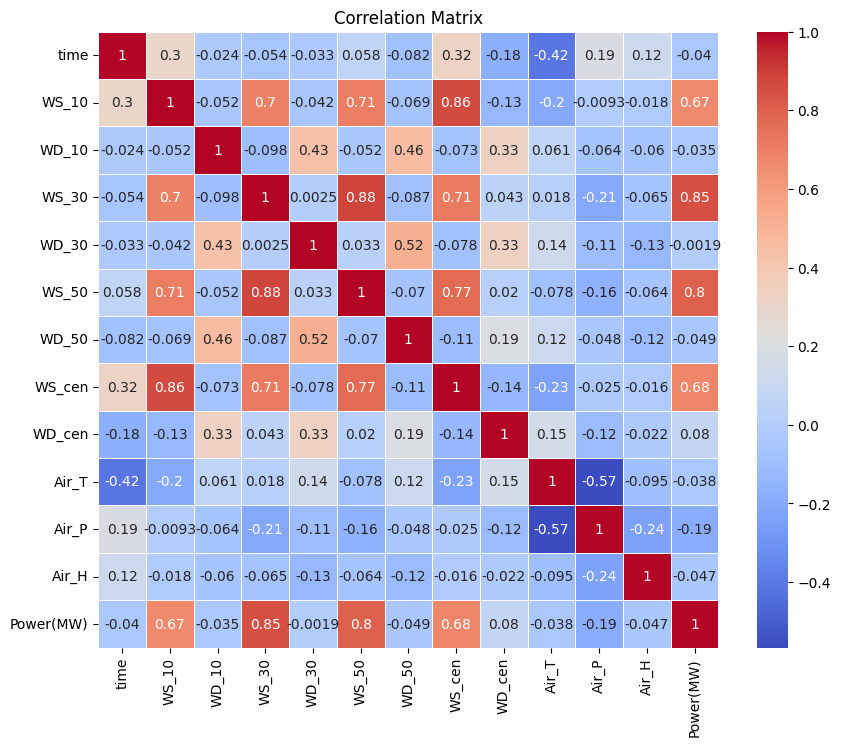

In [108]:
correlation_matrix = df_wf1.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [109]:
pearsonr(df_wf1['WS_10'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.667031746338586, pvalue=0.0)

In [110]:
pearsonr(df_wf1['WS_30'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.8512626819612682, pvalue=0.0)

In [111]:
pearsonr(df_wf1['WS_50'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.7987523815011198, pvalue=0.0)

In [112]:
pearsonr(df_wf1['WS_cen'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.6770283322578311, pvalue=0.0)

With respect to the target variable [Power (MW)], the 4 below features have high correlations on top of very significant pvalues:
- 0.8 with Wind speed at height of 10 meters (m/s)
- 0.84 with Wind speed at height of 30 meters (m/s)
- 0.86 with Wind speed at height of 50 meters (m/s)
- 0.86 with Wind speed - at the height of wheel hub (m/s)

In [113]:
df_wf1.set_index('time', inplace=True)

In [114]:
df_wf1

,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
time,,,,,,,,,,,,
2019-01-01 00:00:00,2.32218,317.431,2.59042,312.468,1.62735,351.117,2.34887,313.33,26.460,984.370,31.7949,-0.365790
2019-01-01 00:15:00,2.32218,317.431,2.59042,312.468,1.62735,351.117,2.34887,313.33,26.460,984.370,31.7949,-0.376874
2019-01-01 00:30:00,2.32218,317.431,2.59042,312.468,1.62735,351.117,2.34887,313.33,26.460,984.370,31.7949,-0.387959
2019-01-01 00:45:00,2.32218,317.431,2.59042,312.468,1.62735,351.117,2.34887,313.33,26.460,984.370,31.7949,-0.395348
2019-01-01 01:00:00,2.32218,317.431,2.59042,312.468,1.62735,351.117,2.34887,313.33,26.460,984.370,31.7949,-0.384264
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 22:45:00,8.62000,159.000,9.04000,172.400,9.67280,162.401,9.61000,167.30,-5.476,977.088,42.4833,57.983200
2020-12-31 23:00:00,8.88000,163.900,8.99000,180.200,9.61930,169.748,8.93000,171.20,-5.197,976.939,42.6886,58.700000
2020-12-31 23:15:00,9.77000,160.600,9.78000,173.600,10.46460,163.531,9.69000,168.20,-5.084,976.790,43.5779,63.178200


In [115]:
df_wf1 = df_wf1.asfreq('15T')
print(df_wf1.index.freq)

<15 * Minutes>


## **Preparing training, testing and demo datasets**

We will slip the entire .csv file into three subdatasets:

- **Modeling**
1. Training (to input training data into forecasting models)
2. Testing (to test forecasting models comparing forcasting with testing data)

- **Demo**
3. Historical (to refit the training+testing with real data after each user forecast request; 1 month of data)

In [116]:
one_month_range = df_wf1.index.max() - pd.DateOffset(months=1)
df_demo = df_wf1[df_wf1.index >= one_month_range]

df_wf1_model = df_wf1[df_wf1.index < one_month_range]

df_wf1_first_50, df_wf1_last_50 = train_test_split(df_wf1_model, train_size = 0.5, test_size = 0.5, shuffle=False)

df_wf1_first_25, df_wf1_second_25 = train_test_split(df_wf1_first_50, train_size = 0.5, test_size = 0.5, shuffle=False)
df_wf1_third_25, df_wf1_fourth_25 = train_test_split(df_wf1_last_50, train_size = 0.5, test_size = 0.5, shuffle=False)

df_wf1_1_train, df_wf1_1_test = train_test_split(df_wf1_first_25, train_size = 0.98, test_size = 0.02, shuffle=False)
df_wf1_2_train, df_wf1_2_test = train_test_split(df_wf1_second_25, train_size = 0.98, test_size = 0.02, shuffle=False)
df_wf1_3_train, df_wf1_3_test = train_test_split(df_wf1_third_25, train_size = 0.98, test_size = 0.02, shuffle=False)
df_wf1_4_train, df_wf1_4_test = train_test_split(df_wf1_fourth_25, train_size = 0.98, test_size = 0.02, shuffle=False)

In [117]:
y_train_1 = df_wf1_1_train[['Power(MW)']]
X_train_1 = df_wf1_1_train[['WS_30', 'WD_cen']]

y_train_2 = df_wf1_2_train[['Power(MW)']]
X_train_2 = df_wf1_2_train[['WS_30', 'WD_cen']]

y_train_3 = df_wf1_3_train[['Power(MW)']]
X_train_3 = df_wf1_3_train[['WS_30', 'WD_cen']]

y_train_4 = df_wf1_4_train[['Power(MW)']]
X_train_4 = df_wf1_4_train[['WS_30', 'WD_cen']]

train_datasets = [(y_train_1, X_train_1), (y_train_2, X_train_2), (y_train_3, X_train_3), (y_train_4, X_train_4)]

In [118]:
y_test_1 = df_wf1_1_test[['Power(MW)']]
X_test_1 = df_wf1_1_test[['WS_30', 'WD_cen']]

y_test_2 = df_wf1_2_test[['Power(MW)']]
X_test_2 = df_wf1_2_test[['WS_30', 'WD_cen']]

y_test_3 = df_wf1_3_test[['Power(MW)']]
X_test_3 = df_wf1_3_test[['WS_30', 'WD_cen']]

y_test_4 = df_wf1_4_test[['Power(MW)']]
X_test_4 = df_wf1_4_test[['WS_30', 'WD_cen']]

test_datasets = [(y_test_1, X_test_1), (y_test_2, X_test_2), (y_test_3, X_test_3), (y_test_4, X_test_4)]

In [119]:
X_test_4

,WS_30,WD_cen
time,,
2020-11-27 11:45:00,6.031,4.685
2020-11-27 12:00:00,4.667,2.748
2020-11-27 12:15:00,6.591,9.900
2020-11-27 12:30:00,5.939,17.540
2020-11-27 12:45:00,5.936,5.411
...,...,...
2020-11-30 22:30:00,1.587,59.250
2020-11-30 22:45:00,0.661,59.290
2020-11-30 23:00:00,0.023,59.440


In [120]:
print(df_wf1.index.freq)

<15 * Minutes>


## **Naïve forecaster model**

In [121]:
naive_predictions_dict = {}

for i, (y_train, _) in enumerate(train_datasets, 1):
    y_test, _ = test_datasets[i - 1]

    forecast_naive = NaiveForecaster(strategy="last")
    forecasted_naive = forecast_naive.fit(y_train)

    forecast_horizon = ForecastingHorizon([i for i in range(1, len(y_test) + 1)])

    predictions_naive = forecasted_naive.predict(fh=forecast_horizon)

    naive_predictions_dict[f'predictions_{i}'] = predictions_naive

y_pred_naive_1 = naive_predictions_dict['predictions_1']
y_pred_naive_2 = naive_predictions_dict['predictions_2']
y_pred_naive_3 = naive_predictions_dict['predictions_3']
y_pred_naive_4 = naive_predictions_dict['predictions_4']

## **Linear regression model**

In [122]:
linear_predictions_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    _, X_test = test_datasets[i - 1]

    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    
    predictions_linear = linear_model.predict(X_test)
    predictions_linear_df = pd.DataFrame(predictions_linear, index=X_test.index, columns=['Predicted Power(MW)'])

    linear_predictions_dict[f'predictions_{i}'] = predictions_linear_df

y_pred_linear_1 = linear_predictions_dict['predictions_1']
y_pred_linear_2 = linear_predictions_dict['predictions_2']
y_pred_linear_3 = linear_predictions_dict['predictions_3']
y_pred_linear_4 = linear_predictions_dict['predictions_4']

## **LSTM - Long short-term memory model**

In [123]:
def train_and_forecast_lstm(X_train, y_train, X_test):
    X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

    model_lstm = Sequential()
    model_lstm.add(LSTM(units=85, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model_lstm.add(Dense(units=1))
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')

    model_lstm.fit(X_train_lstm, y_train, epochs=80, batch_size=50, verbose=0)

    predictions = model_lstm.predict(X_test_lstm)
    predictions_lstm = pd.DataFrame(predictions, index=X_test.index, columns=['Predicted Power(MW)'])

    return predictions_lstm

train_datasets = [(y_train_1, X_train_1), (y_train_2, X_train_2), (y_train_3, X_train_3), (y_train_4, X_train_4)]
test_datasets = [(y_test_1, X_test_1), (y_test_2, X_test_2), (y_test_3, X_test_3), (y_test_4, X_test_4)]

predictions_lstm_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]
    
    predictions_lstm = train_and_forecast_lstm(X_train, y_train, X_test)
    
    predictions_lstm_dict[f'predictions_{i}'] = predictions_lstm

y_pred_lstm_1 = predictions_lstm_dict['predictions_1']
y_pred_lstm_2 = predictions_lstm_dict['predictions_2']
y_pred_lstm_3 = predictions_lstm_dict['predictions_3']
y_pred_lstm_4 = predictions_lstm_dict['predictions_4']

C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


## **Random Forest model**

In [124]:
predictions_randomforest_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]
    
    randomforest_regressor = RandomForestRegressor(bootstrap=True, n_estimators=800, random_state=42)
    randomforest_regressor.fit(X_train, y_train)
    
    predictions = randomforest_regressor.predict(X_test)
    predictions_randomforest = pd.DataFrame(predictions, index=y_test.index, columns=['Predicted Power(MW)'])
    
    predictions_randomforest_dict[f'predictions_{i}'] = predictions_randomforest

y_pred_randomforest_1 = predictions_randomforest_dict['predictions_1']
y_pred_randomforest_2 = predictions_randomforest_dict['predictions_2']
y_pred_randomforest_3 = predictions_randomforest_dict['predictions_3']
y_pred_randomforest_4 = predictions_randomforest_dict['predictions_4']

C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

## **XGBoost model**

In [125]:
predictions_xgboost_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]

    xgboost_model = xgb.XGBRegressor(max_depth=3, learning_rate=0.11, n_estimators=62)
    xgboost_model.fit(X_train, y_train)
    
    predictions = xgboost_model.predict(X_test)
    predictions_xgboost = pd.DataFrame(predictions, index=y_test.index, columns=['Predicted Power(MW)'])

    predictions_xgboost_dict[f'predictions_{i}'] = predictions_xgboost

y_pred_xgboost_1 = predictions_xgboost_dict['predictions_1']
y_pred_xgboost_2 = predictions_xgboost_dict['predictions_2']
y_pred_xgboost_3 = predictions_xgboost_dict['predictions_3']
y_pred_xgboost_4 = predictions_xgboost_dict['predictions_4']

## **Reduction Random Forest model**

In [126]:
predictions_reduction_randomforest_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]
    
    forecaster = make_reduction(randomforest_regressor, strategy='recursive', window_length=5)
    forecaster.fit(y_train)
    
    horizon = list(range(1, len(y_test) + 1))
    predictions_reductions_recursive = forecaster.predict(fh=horizon)
    
    predictions_reduction_randomforest_dict[f'predictions_{i}'] = predictions_reductions_recursive

y_pred_reduction_randomforest_1 = predictions_reduction_randomforest_dict['predictions_1']
y_pred_reduction_randomforest_2 = predictions_reduction_randomforest_dict['predictions_2']
y_pred_reduction_randomforest_3 = predictions_reduction_randomforest_dict['predictions_3']
y_pred_reduction_randomforest_4 = predictions_reduction_randomforest_dict['predictions_4']

## **Reduction XGBoost model**

In [127]:
predictions_reduction_xgboost_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]
    
    #forecaster = make_reduction(xgboost_model, strategy='recursive', window_length=200)
    forecaster = make_reduction(xgboost_model, strategy='recursive', window_length=5)
    forecaster.fit(y_train)
    
    horizon = list(range(1, len(y_test) + 1))
    predictions_reductions_recursive = forecaster.predict(fh=horizon)
    
    predictions_reduction_xgboost_dict[f'predictions_{i}'] = predictions_reductions_recursive

y_pred_reduction_xgboost_1 = predictions_reduction_xgboost_dict['predictions_1']
y_pred_reduction_xgboost_2 = predictions_reduction_xgboost_dict['predictions_2']
y_pred_reduction_xgboost_3 = predictions_reduction_xgboost_dict['predictions_3']
y_pred_reduction_xgboost_4 = predictions_reduction_xgboost_dict['predictions_4']

## **Summary**

In [128]:
mae_naive_1 = mean_absolute_error(y_test_1, y_pred_naive_1)
mae_naive_2 = mean_absolute_error(y_test_2, y_pred_naive_2)
mae_naive_3 = mean_absolute_error(y_test_3, y_pred_naive_3)
mae_naive_4 = mean_absolute_error(y_test_4, y_pred_naive_4)
average_mae_naive = (mae_naive_1 + mae_naive_2 + mae_naive_3 + mae_naive_4) / 4

mae_linear_1 = mean_absolute_error(y_test_1, y_pred_linear_1)
mae_linear_2 = mean_absolute_error(y_test_2, y_pred_linear_2)
mae_linear_3 = mean_absolute_error(y_test_3, y_pred_linear_3)
mae_linear_4 = mean_absolute_error(y_test_4, y_pred_linear_4)
average_mae_linear = (mae_linear_1 + mae_linear_2 + mae_linear_3 + mae_linear_4) / 4

mae_lstm_1 = mean_absolute_error(y_test_1, y_pred_lstm_1)
mae_lstm_2 = mean_absolute_error(y_test_2, y_pred_lstm_2)
mae_lstm_3 = mean_absolute_error(y_test_3, y_pred_lstm_3)
mae_lstm_4 = mean_absolute_error(y_test_4, y_pred_lstm_4)
average_mae_lstm = (mae_lstm_1 + mae_lstm_2 + mae_lstm_3 + mae_lstm_4) / 4

mae_randomforest_1 = mean_absolute_error(y_test_1, y_pred_randomforest_1)
mae_randomforest_2 = mean_absolute_error(y_test_2, y_pred_randomforest_2)
mae_randomforest_3 = mean_absolute_error(y_test_3, y_pred_randomforest_3)
mae_randomforest_4 = mean_absolute_error(y_test_4, y_pred_randomforest_4)
average_mae_randomforest = (mae_randomforest_1 + mae_randomforest_2 + mae_randomforest_3 + mae_randomforest_4) / 4

mae_xgboost_1 = mean_absolute_error(y_test_1, y_pred_xgboost_1)
mae_xgboost_2 = mean_absolute_error(y_test_2, y_pred_xgboost_2)
mae_xgboost_3 = mean_absolute_error(y_test_3, y_pred_xgboost_3)
mae_xgboost_4 = mean_absolute_error(y_test_4, y_pred_xgboost_4)
average_mae_xgboost = (mae_xgboost_1 + mae_xgboost_2 + mae_xgboost_3 + mae_xgboost_4) / 4

mae_reduction_randomforest_1 = mean_absolute_error(y_test_1, y_pred_reduction_randomforest_1)
mae_reduction_randomforest_2 = mean_absolute_error(y_test_2, y_pred_reduction_randomforest_2)
mae_reduction_randomforest_3 = mean_absolute_error(y_test_3, y_pred_reduction_randomforest_3)
mae_reduction_randomforest_4 = mean_absolute_error(y_test_4, y_pred_reduction_randomforest_4)
average_mae_reduction_randomforest = (mae_reduction_randomforest_1 + mae_reduction_randomforest_2 + mae_reduction_randomforest_3 + mae_reduction_randomforest_4) / 4

mae_reduction_xgboost_1 = mean_absolute_error(y_test_1, y_pred_reduction_xgboost_1)
mae_reduction_xgboost_2 = mean_absolute_error(y_test_2, y_pred_reduction_xgboost_2)
mae_reduction_xgboost_3 = mean_absolute_error(y_test_3, y_pred_reduction_xgboost_3)
mae_reduction_xgboost_4 = mean_absolute_error(y_test_4, y_pred_reduction_xgboost_4)
average_mae_reduction_xgboost = (mae_reduction_xgboost_1 + mae_reduction_xgboost_2 + mae_reduction_xgboost_3 + mae_reduction_xgboost_4) / 4

In [129]:
models = [
    "Naive Forecaster",
    "Linear Regression",
    "LSTM (epochs=80, batch_size=50)", 
    "Random Forest (n_estimators=100, random_state=42)", 
    "XGBoost (max_depth=3, learning_rate=0.11, n_estimators=62)",
    "Reduction + Random Forest (window_length=5)",
    "Reduction + XGBoost (window_length=5)"
]

maes = [
    [mae_naive_1, mae_naive_2, mae_naive_3, mae_naive_4, average_mae_naive],
    [mae_linear_1, mae_linear_2, mae_linear_3, mae_linear_4, average_mae_linear],
    [mae_lstm_1, mae_lstm_2, mae_lstm_3, mae_lstm_4, average_mae_lstm],
    [mae_randomforest_1, mae_randomforest_2, mae_randomforest_3, mae_randomforest_4, average_mae_randomforest],
    [mae_xgboost_1, mae_xgboost_2, mae_xgboost_3, mae_xgboost_4, average_mae_xgboost],
    [mae_reduction_randomforest_1, mae_reduction_randomforest_2, mae_reduction_randomforest_3, mae_reduction_randomforest_4, average_mae_reduction_randomforest],
    [mae_reduction_xgboost_1, mae_reduction_xgboost_2, mae_reduction_xgboost_3, mae_reduction_xgboost_4, average_mae_reduction_xgboost]
]

headers = ["Model", "MAE 1", "MAE 2", "MAE 3", "MAE 4", "Average MAE"]
table_data = []

for model, mae_list in zip(models, maes):
    table_data.append([model] + mae_list)

print(tabulate(table_data, headers=headers, tablefmt="grid"))

+------------------------------------------------------------+----------+---------+----------+----------+---------------+
| Model                                                      |    MAE 1 |   MAE 2 |    MAE 3 |    MAE 4 |   Average MAE |
+============================================================+==========+=========+==========+==========+===============+
| Naive Forecaster                                           | 14.956   | 7.99867 | 15.5266  | 13.1636  |      12.9112  |
+------------------------------------------------------------+----------+---------+----------+----------+---------------+
| Linear Regression                                          |  9.99991 | 6.59751 |  8.18787 |  5.58776 |       7.59326 |
+------------------------------------------------------------+----------+---------+----------+----------+---------------+
| LSTM (epochs=80, batch_size=50)                            |  8.92596 | 4.22896 |  6.17045 |  2.1074  |       5.3582  |
+-----------------------

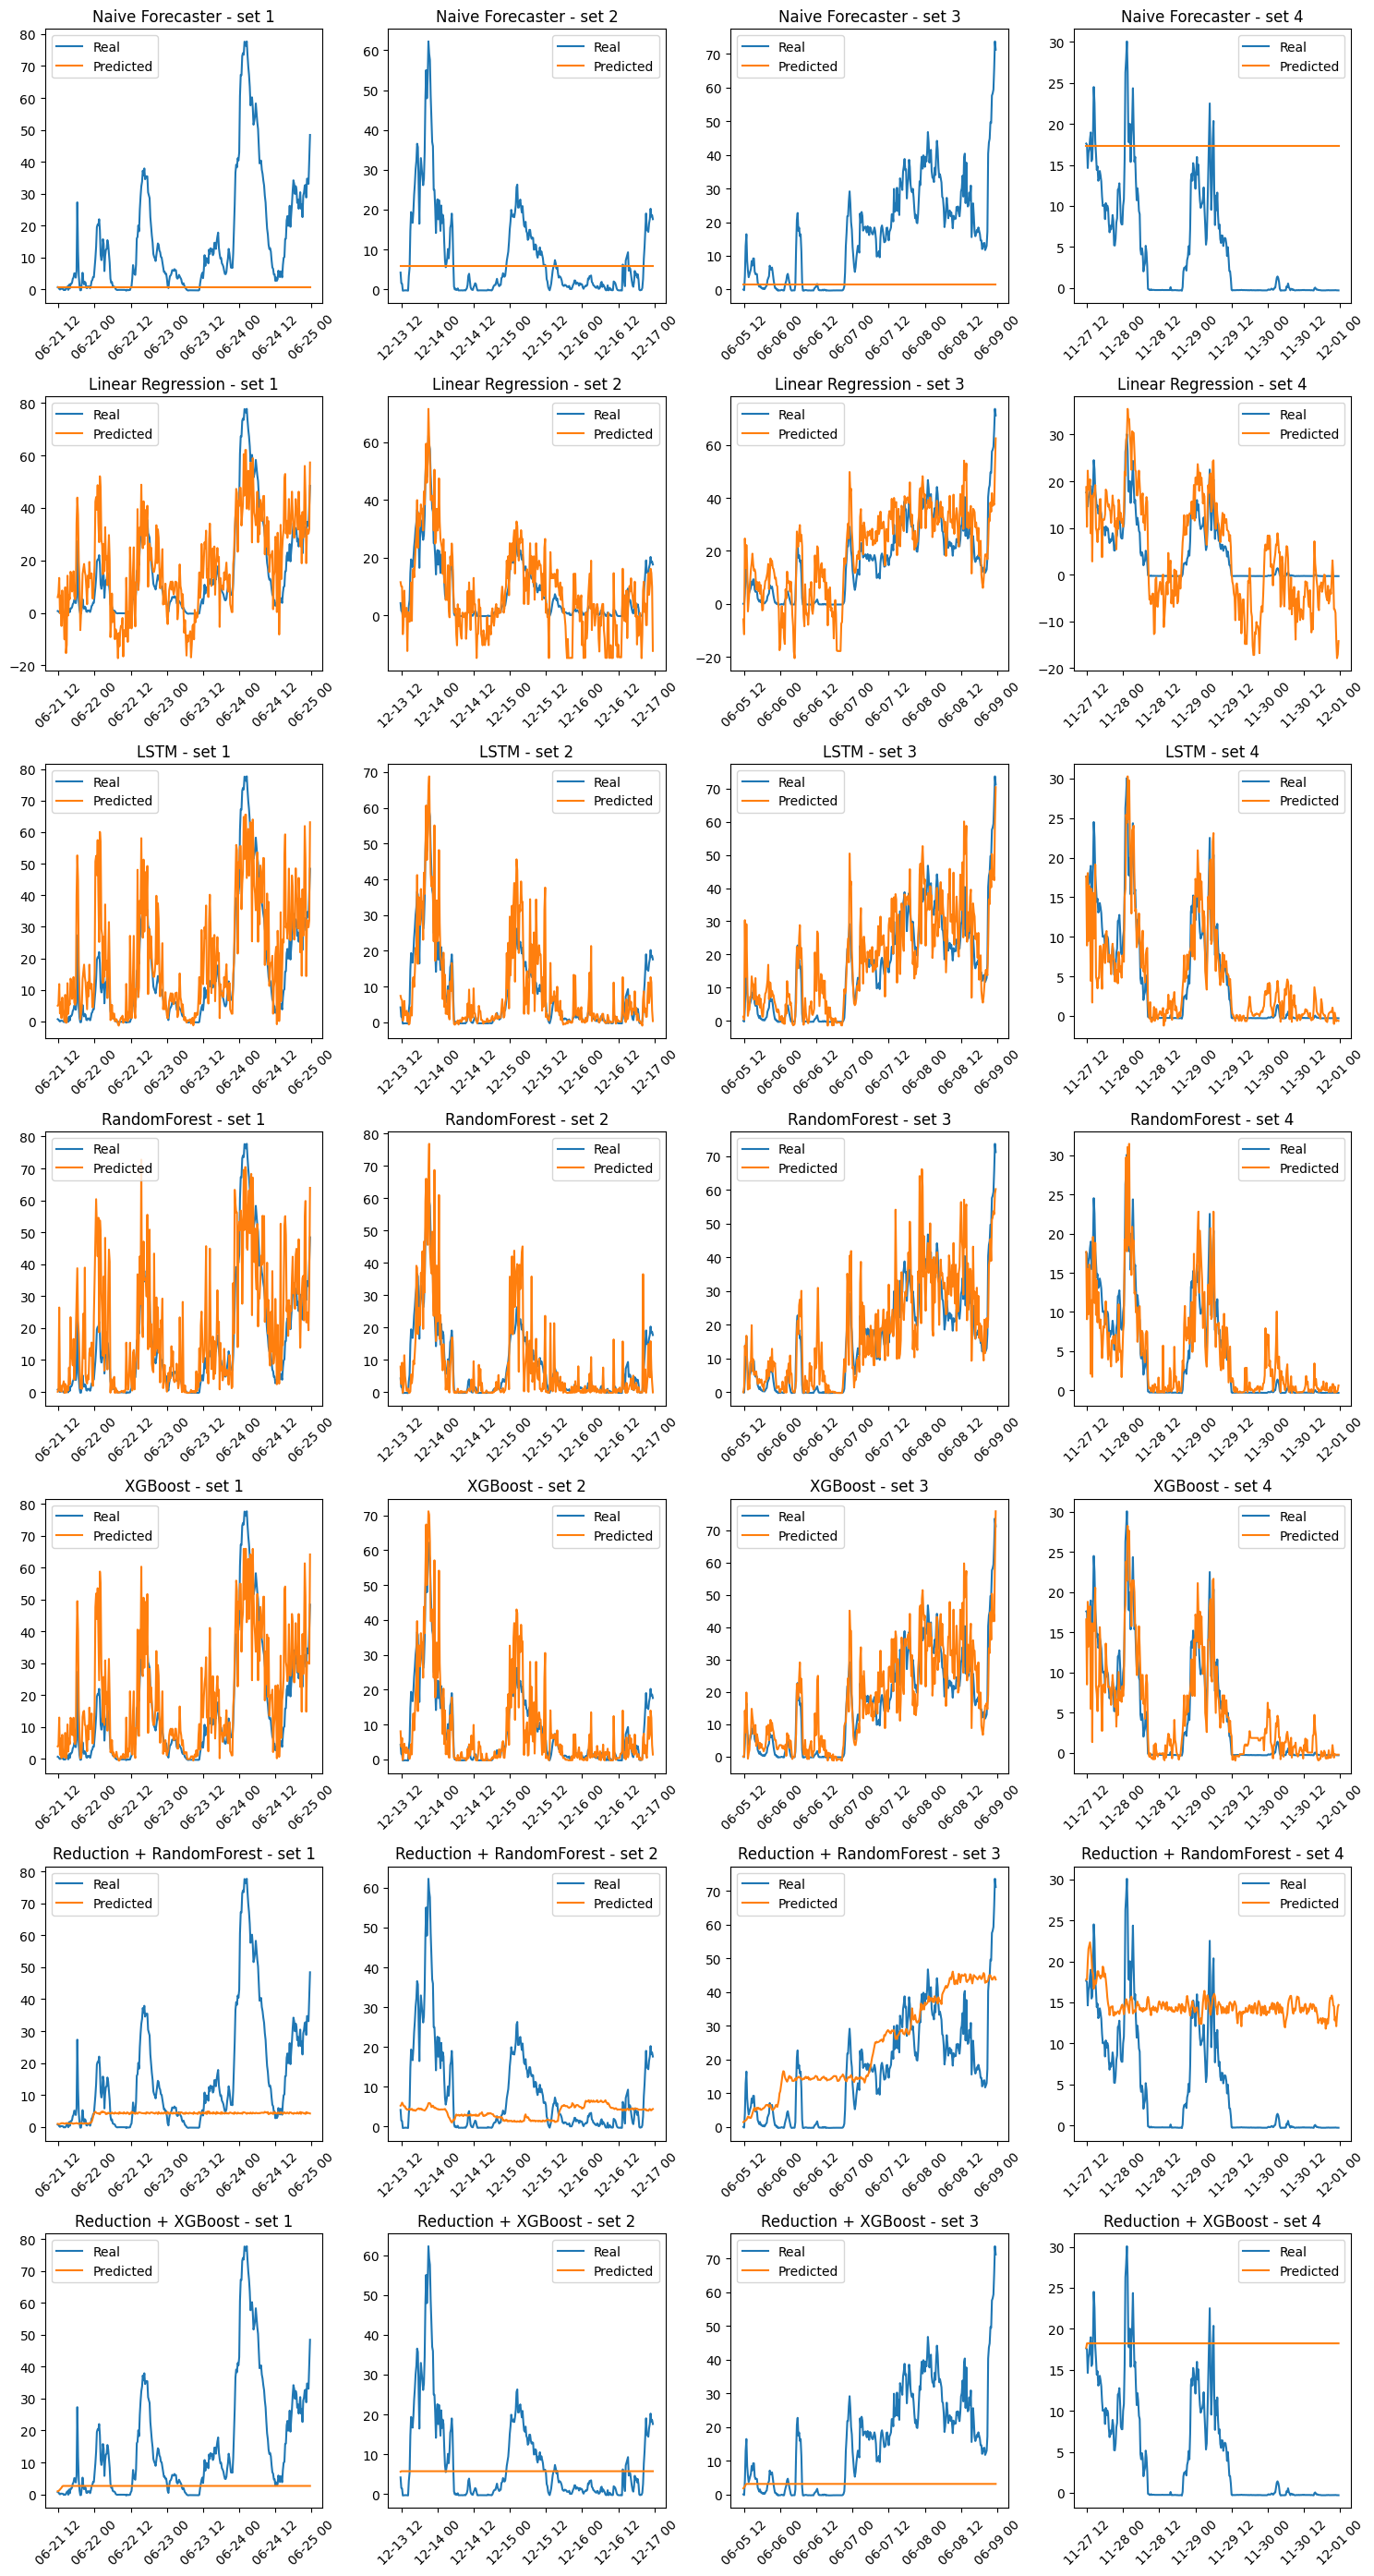

In [130]:
plt.figure(figsize=(15, 28))

# Plot Naive Forecaster
plt.subplot(7, 4, 1)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_naive_1, label='Predicted')
plt.title('Naive Forecaster - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 2)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_naive_2, label='Predicted')
plt.title('Naive Forecaster - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 3)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_naive_3, label='Predicted')
plt.title('Naive Forecaster - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 4)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_naive_4, label='Predicted')
plt.title('Naive Forecaster - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot Linear Regression
plt.subplot(7, 4, 5)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_linear_1, label='Predicted')
plt.title('Linear Regression - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 6)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_linear_2, label='Predicted')
plt.title('Linear Regression - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 7)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_linear_3, label='Predicted')
plt.title('Linear Regression - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 8)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_linear_4, label='Predicted')
plt.title('Linear Regression - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot LSTM
plt.subplot(7, 4, 9)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_lstm_1, label='Predicted')
plt.title('LSTM - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 10)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_lstm_2, label='Predicted')
plt.title('LSTM - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 11)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_lstm_3, label='Predicted')
plt.title('LSTM - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 12)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_lstm_4, label='Predicted')
plt.title('LSTM - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot RandomForest
plt.subplot(7, 4, 13)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_randomforest_1, label='Predicted')
plt.title('RandomForest - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 14)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_randomforest_2, label='Predicted')
plt.title('RandomForest - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 15)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_randomforest_3, label='Predicted')
plt.title('RandomForest - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 16)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_randomforest_4, label='Predicted')
plt.title('RandomForest - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot XGBoost
plt.subplot(7, 4, 17)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_xgboost_1, label='Predicted')
plt.title('XGBoost - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 18)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_xgboost_2, label='Predicted')
plt.title('XGBoost - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 19)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_xgboost_3, label='Predicted')
plt.title('XGBoost - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 20)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_xgboost_4, label='Predicted')
plt.title('XGBoost - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot Reduction + RandomForest
plt.subplot(7, 4, 21)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_reduction_randomforest_1, label='Predicted')
plt.title('Reduction + RandomForest - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 22)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_reduction_randomforest_2, label='Predicted')
plt.title('Reduction + RandomForest - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 23)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_reduction_randomforest_3, label='Predicted')
plt.title('Reduction + RandomForest - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 24)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_reduction_randomforest_4, label='Predicted')
plt.title('Reduction + RandomForest - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot Reduction + XGBoost
plt.subplot(7, 4, 25)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_reduction_xgboost_1, label='Predicted')
plt.title('Reduction + XGBoost - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 26)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_reduction_xgboost_2, label='Predicted')
plt.title('Reduction + XGBoost - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 27)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_reduction_xgboost_3, label='Predicted')
plt.title('Reduction + XGBoost - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 28)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_reduction_xgboost_4, label='Predicted')
plt.title('Reduction + XGBoost - set 4')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## **Backtesting**

In [131]:
#model_lstm.update(df_wf1_test)